In [1]:
!pip install -r requirements.txt

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import validation_curve,learning_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier

# Import Data

In [148]:
# Car data
car_df = pd.read_csv('./data/car_data.csv')

# Breast Cancer data 
cancer_df = pd.read_csv('./data/breast-cancer-wisconsin_data.csv')

# Wine quality data
wine_df = pd.read_csv('./data/winequality-white.csv', sep=';')

print("---------------------------- Car Evaluation Data --------------------------------------")
print(car_df.head())

print("---------------------------- Breast Cancer Data ---------------------------------------")
print(cancer_df.head())

print("---------------------------- Wine Quality Data -----------------------------------------")
print(wine_df.head())

---------------------------- Car Evaluation Data --------------------------------------
  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc
---------------------------- Breast Cancer Data ---------------------------------------
   Sample code number  Clump Thickness  Uniformity of Cell Size  \
0             1000025                5                        1   
1             1002945                5                        4   
2             1015425                3                        1   
3             1016277                6                        8   
4             1017023                4                        1   

   Uniformity of Cell Shape  Marginal Adhesion  Single Epithelial Cell Size  \
0                       

In [149]:
print(car_df.shape)
print(cancer_df.shape)
print(wine_df.shape)

(1728, 7)
(699, 11)
(4898, 12)


In [150]:
print("---------------------------- Car Evaluation Data --------------------------------------")
print(car_df['class'].value_counts(normalize=True))

print("---------------------------- Breast Cancer Data ---------------------------------------")
print(cancer_df['Class'].value_counts(normalize=True))

print("---------------------------- Wine Quality Data -----------------------------------------")
print(wine_df['quality'].value_counts(normalize=True))

---------------------------- Car Evaluation Data --------------------------------------
unacc    0.700231
acc      0.222222
good     0.039931
vgood    0.037616
Name: class, dtype: float64
---------------------------- Breast Cancer Data ---------------------------------------
2    0.655222
4    0.344778
Name: Class, dtype: float64
---------------------------- Wine Quality Data -----------------------------------------
6    0.448755
5    0.297468
7    0.179665
8    0.035729
4    0.033279
3    0.004083
9    0.001021
Name: quality, dtype: float64


In [151]:
# Data Pre-Processing

scaler = StandardScaler()
def process_car(df):
    #df['class'].map({'unacc': 0, 'acc': 1, 'good': 1, 'vgood': 1})
    df['class'] = np.where(df['class'] == 'unacc', 0, 1)
    df1 = pd.get_dummies(df, columns=['buying','maint','doors','persons','lug_boot','safety'])
    X = df1.drop('class', axis = 1)
    y = df1['class'].values
    return X,y

def process_cancer(df):
    #df['Class'].map({4: 1, 2: 0})
    df['Class'] = np.where(df['Class'] == 2, 0, 1)
    df.drop('Sample code number', axis = 1, inplace = True)
    # Dropping records with missing values of Bare Nuclei and converting it to numeric
    df = df[df['Bare Nuclei'] != '?']
    df['Bare Nuclei'] = pd.to_numeric(df['Bare Nuclei'])
    X = df.drop('Class', axis = 1)
    y = df.Class.values
    # Features scaling
    scaler.fit(X)
    return X,y

def process_wine(df):
    df['quality'] = np.where(df['quality'] >= 6, 1, 0)
    X = df.drop('quality', axis = 1)
    y = df.quality.values
    scaler.fit(X)
    X = scaler.transform(X)
    return X,y

car_X, car_y = process_car(car_df)
cancer_X, cancer_y = process_cancer(cancer_df)
wine_X, wine_y = process_wine(wine_df)
#print(wine_X[:5])
#print(car_df.head())

/var/folders/49/s47xmzpx1zsg5t1_3y45j9sm0000gn/T/ipykernel_87084/3769010964.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bare Nuclei'] = pd.to_numeric(df['Bare Nuclei'])


In [152]:
wine_X

array([[ 1.72096961e-01, -8.17699008e-02,  2.13280202e-01, ...,
        -1.24692128e+00, -3.49184257e-01, -1.39315246e+00],
       [-6.57501128e-01,  2.15895632e-01,  4.80011213e-02, ...,
         7.40028640e-01,  1.34184656e-03, -8.24275678e-01],
       [ 1.47575110e+00,  1.74519434e-02,  5.43838363e-01, ...,
         4.75101984e-01, -4.36815783e-01, -3.36667007e-01],
       ...,
       [-4.20473102e-01, -3.79435433e-01, -1.19159198e+00, ...,
        -1.31315295e+00, -2.61552731e-01, -9.05543789e-01],
       [-1.60561323e+00,  1.16673788e-01, -2.82557040e-01, ...,
         1.00495530e+00, -9.62604939e-01,  1.85757201e+00],
       [-1.01304317e+00, -6.77100966e-01,  3.78559282e-01, ...,
         4.75101984e-01, -1.48839409e+00,  1.04489089e+00]])

<AxesSubplot:>

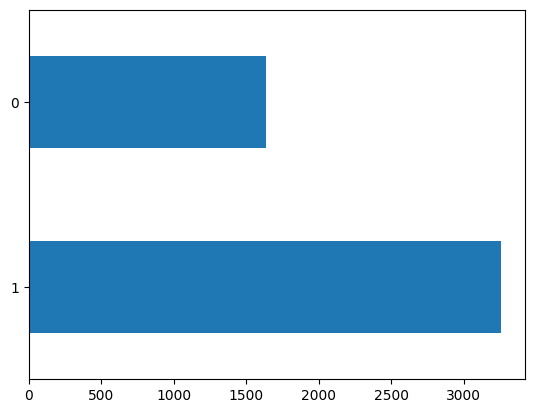

In [153]:
wine_df['quality'].value_counts().plot(kind='barh')

In [154]:
wine_df['quality'].value_counts()

1    3258
0    1640
Name: quality, dtype: int64

# Wine dataset Analysis

In [155]:
X_train, X_test, y_train, y_test = train_test_split(wine_X, wine_y, test_size = 0.3, random_state = 5)

# Decision Tree

In [156]:
dt_clf = tree.DecisionTreeClassifier(random_state = 1)
dt_clf.fit(X_train,y_train)
y_pred = dt_clf.predict(X_test)
print("Baseline Accuracy score", accuracy_score(y_test,y_pred))
print("Baseline Balanced Accuracy score", balanced_accuracy_score(y_test, y_pred))
print("Baseline F1 score", f1_score(y_test, y_pred))

Baseline Accuracy score 0.7659863945578231
Baseline Balanced Accuracy score 0.7320901320901321
Baseline F1 score 0.8257345491388045


In [157]:
# On cross-validation data
req_scores = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
results = cross_validate(estimator=dt_clf, X = X_train, y = y_train, cv = 5, scoring = req_scores, 
                         return_train_score=True)
results
print("Baseline Accuracy score", results['test_accuracy'].mean())
print("Baseline Balanced Accuracy score", results['test_balanced_accuracy'].mean())
print("Baseline F1 score", results['test_f1'].mean())

Baseline Accuracy score 0.7584639611840565
Baseline Balanced Accuracy score 0.7318090499077904
Baseline F1 score 0.8175116166946891


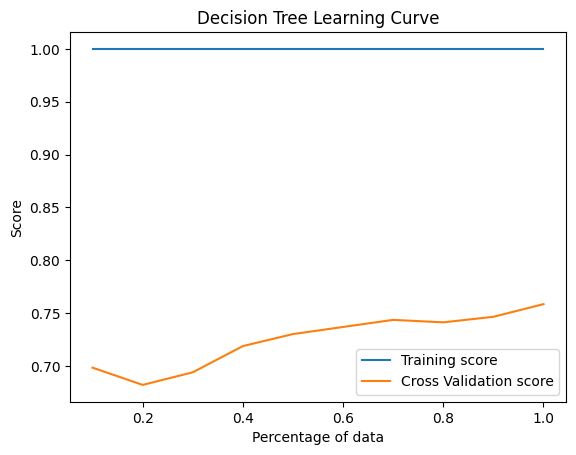

In [158]:
# Learning Curve before tuning. This should be carried out after tuning as well.
train_data_size = np.linspace(0.1,1,10)
_, train_scores, cv_scores = learning_curve(dt_clf, X_train, y_train, train_sizes = train_data_size, cv = 5, n_jobs = 4)
plt.figure()
plt.plot(train_data_size, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(train_data_size, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('Decision Tree Learning Curve')
plt.xlabel('Percentage of data')
plt.ylabel('Score')
plt.legend()
plt.show()

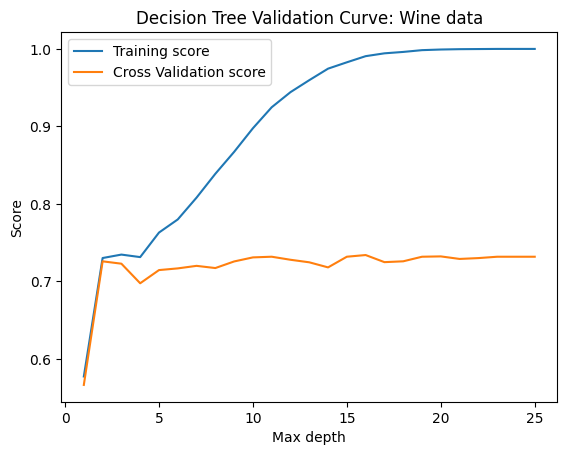

In [159]:
# Validation Curve
depth_trees = np.arange(1, 26, 1)

train_scores, cv_scores = validation_curve(dt_clf, X_train, y_train, 
                                           param_name="max_depth", param_range=depth_trees,scoring='balanced_accuracy', cv=5, n_jobs=4)
plt.figure()
plt.plot(depth_trees, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(depth_trees, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('Decision Tree Validation Curve: Wine data')
plt.xlabel('Max depth')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/DT_VC_depth_wine.png')
plt.show()

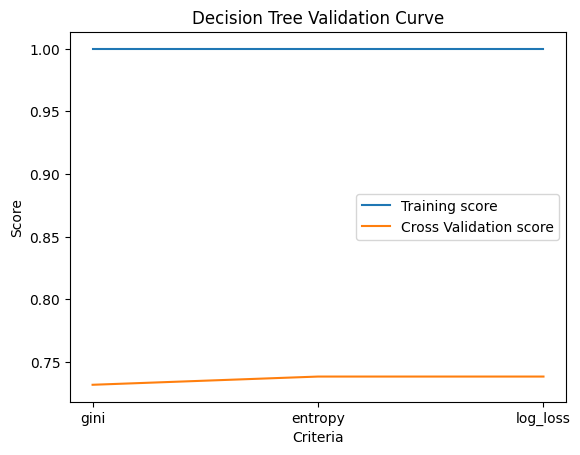

In [160]:
depth_trees = np.arange(1, 26, 1)
criteria_params = ["gini","entropy","log_loss"]
train_scores, cv_scores = validation_curve(dt_clf, X_train, y_train, 
                                           param_name="criterion", param_range=criteria_params,scoring='balanced_accuracy', cv=5, n_jobs=4)
plt.figure()
plt.plot(criteria_params, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(criteria_params, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('Decision Tree Validation Curve')
plt.xlabel('Criteria')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/DT_VC_criteria_wine.png')
plt.show()

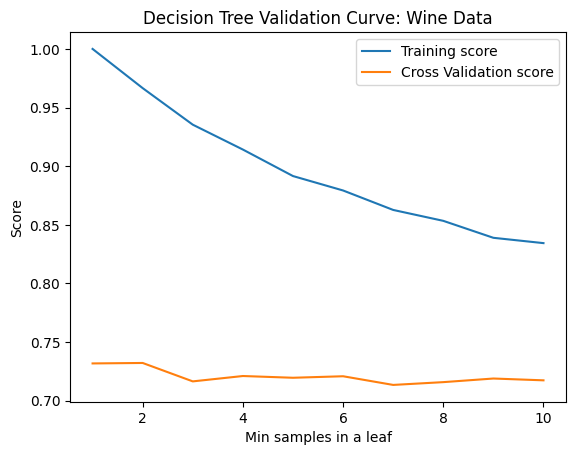

In [161]:
samples_val = np.arange(1, 11, 1)

train_scores, cv_scores = validation_curve(dt_clf, X_train, y_train, 
                                           param_name="min_samples_leaf", param_range=samples_val,scoring='balanced_accuracy', cv=5, n_jobs=4)
plt.figure()
plt.plot(samples_val, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(samples_val, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('Decision Tree Validation Curve: Wine Data')
plt.xlabel('Min samples in a leaf')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/DT_VC_leaf_wine.png')
plt.show()

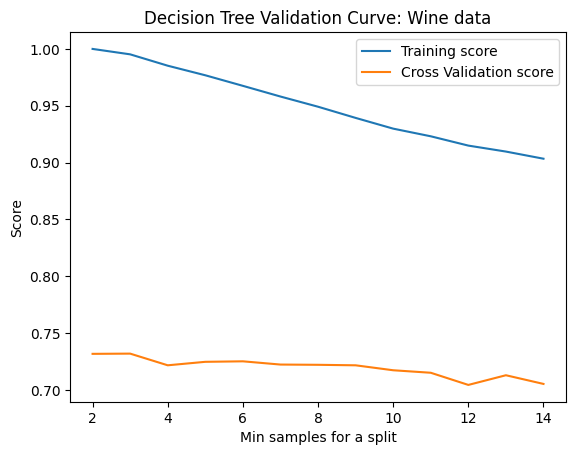

In [162]:
samples_val = np.arange(2, 15, 1)

train_scores, cv_scores = validation_curve(dt_clf, X_train, y_train, 
                                           param_name="min_samples_split", param_range=samples_val,
                                           scoring='balanced_accuracy', cv=5, n_jobs=4)
plt.figure()
plt.plot(samples_val, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(samples_val, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('Decision Tree Validation Curve: Wine data')
plt.xlabel('Min samples for a split')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/DT_VC_split_wine.png')
plt.show()

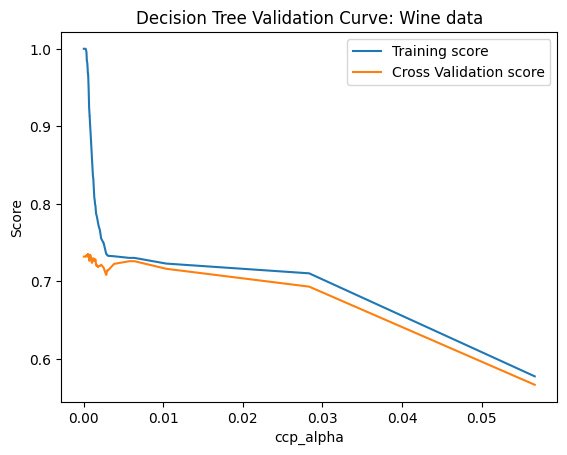

In [163]:
# Citation: https://www.analyticsvidhya.com/blog/2020/10/cost-complexity-pruning-decision-trees/
path = dt_clf.cost_complexity_pruning_path(X_train, y_train)
alphas = path['ccp_alphas']
# Best alpha: 0.001256


train_scores, cv_scores = validation_curve(dt_clf, X_train, y_train, 
                                           param_name="ccp_alpha", param_range=alphas,
                                           scoring='balanced_accuracy',cv=5, n_jobs=4)
plt.figure()
plt.plot(alphas, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(alphas, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('Decision Tree Validation Curve: Wine data')
plt.xlabel('ccp_alpha')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/DT_VC_alpha_wine.png')
plt.show()

In [59]:
# Hyperparameters tuning using GridSearch CV
depth_trees = np.arange(1, 11, 1)
criteria_params = ["gini","entropy","log_loss"]
#criteria_params = ["gini"]
leaf_samples_val = np.arange(1, 11, 1)
split_samples_val = np.arange(2, 11, 1)
#split_samples_val = [2]
ccp_list = [0.001256]

params_gridsearch = {'max_depth': depth_trees, 'criterion': criteria_params, 
                     'min_samples_leaf': leaf_samples_val,'min_samples_split': split_samples_val, 'ccp_alpha': ccp_list}

dt_clf_gs = GridSearchCV(tree.DecisionTreeClassifier(random_state = 7), param_grid = params_gridsearch, scoring = 'balanced_accuracy', cv = 5, n_jobs=4)
init_time = time.time()
dt_clf_gs.fit(X_train, y_train)
print("Grid Search took {} seconds ".format(time.time() - init_time))
best_params = dt_clf_gs.best_params_
print("Best parameters: ", best_params)


Grid Search took 31.469104290008545 seconds 
Best parameters:  {'ccp_alpha': 0.001256, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 8}


In [165]:
best_dt = tree.DecisionTreeClassifier(random_state = 2, max_depth = 10, ccp_alpha = 0.001256,
                                      min_samples_leaf = 2, min_samples_split = 8, criterion = 'gini')
req_scores = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
results = cross_validate(estimator=best_dt, X = X_train, y = y_train, cv = 5, scoring = req_scores, 
                         return_train_score=True)
results
print("Tuned Model Accuracy score", results['test_accuracy'].mean())
print("Tuned Model Balanced Accuracy score", results['test_balanced_accuracy'].mean())
print("Tuned Model F1 score", results['test_f1'].mean())

Tuned Model Accuracy score 0.7657551446021579
Tuned Model Balanced Accuracy score 0.7270538719353399
Tuned Model F1 score 0.8275239475527405


In [167]:
best_dt = tree.DecisionTreeClassifier(random_state = 2, max_depth = 10, ccp_alpha = 0.001256,
                                      min_samples_leaf = 2, min_samples_split = 8, criterion = 'gini')
best_dt.fit(X_train, y_train)
print("Tuned Model Test Results")
y_pred = best_dt.predict(X_test)
print("Tuned Model Accuracy score", accuracy_score(y_test,y_pred))
print("Tuned Model Balanced Accuracy score", balanced_accuracy_score(y_test, y_pred))
print("Tuned Model F1 score", f1_score(y_test, y_pred))

Tuned Model Test Results
Tuned Model Accuracy score 0.7557823129251701
Tuned Model Balanced Accuracy score 0.7194250194250195
Tuned Model F1 score 0.8185952501263265


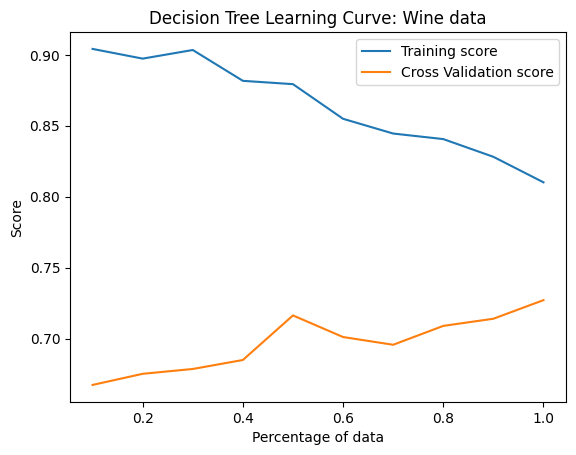

In [169]:
# Learning Curve after tuning. 
best_dt = tree.DecisionTreeClassifier(random_state = 2, max_depth = 10, ccp_alpha = 0.001256,
                                      min_samples_leaf = 2, min_samples_split = 8, criterion = 'gini')
best_dt.fit(X_train,y_train)
train_data_size = np.linspace(0.1,1,10)
_, train_scores, cv_scores = learning_curve(best_dt, X_train, y_train, train_sizes = train_data_size, scoring = 'balanced_accuracy',cv = 5, n_jobs = 4)
plt.figure()
plt.plot(train_data_size, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(train_data_size, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('Decision Tree Learning Curve: Wine data')
plt.xlabel('Percentage of data')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/DT_LC_wine.png')
plt.show()

In [21]:
# Training time 
best_dt = tree.DecisionTreeClassifier(random_state = 3, max_depth = 5, ccp_alpha = 0.001256,
                                      min_samples_leaf = 2, min_samples_split = 5, criterion = 'gini')
init_time = time.time()
best_dt.fit(X_train,y_train)
print("Training time in seconds:", time.time() - init_time)
init_time = time.time()
y_pred = dt_clf.predict(X_test)
print("Query time in seconds:", time.time() - init_time)

Training time in seconds: 0.008285045623779297
Query time in seconds: 0.0009241104125976562


In [171]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.61      0.65      0.63       466
           1       0.83      0.81      0.82      1004

    accuracy                           0.76      1470
   macro avg       0.72      0.73      0.72      1470
weighted avg       0.76      0.76      0.76      1470



# Boosting

In [173]:
dt_stumps = tree.DecisionTreeClassifier(max_depth = 1,random_state = 4)
boosting_clf = AdaBoostClassifier(base_estimator = dt_stumps, random_state = 5)
boosting_clf.fit(X_train, y_train)
y_pred = boosting_clf.predict(X_test)
print("Baseline Accuracy score", accuracy_score(y_test,y_pred))
print("Baseline Balanced Accuracy score", balanced_accuracy_score(y_test, y_pred))
print("Baseline F1 score", f1_score(y_test, y_pred))

Baseline Accuracy score 0.754421768707483
Baseline Balanced Accuracy score 0.7079564879564879
Baseline F1 score 0.8211986131748391


In [174]:
# On cross-validation data
req_scores = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
results = cross_validate(estimator=boosting_clf, X = X_train, y = y_train, cv = 5, scoring = req_scores, 
                         return_train_score=True)
results
print("Baseline Accuracy score", results['test_accuracy'].mean())
print("Baseline Balanced Accuracy score", results['test_balanced_accuracy'].mean())
print("Baseline F1 score", results['test_f1'].mean())

Baseline Accuracy score 0.7564125045221426
Baseline Balanced Accuracy score 0.7089387593519169
Baseline F1 score 0.8232726328374163


Validation curve for no of estimators took 35.67498588562012 seconds 


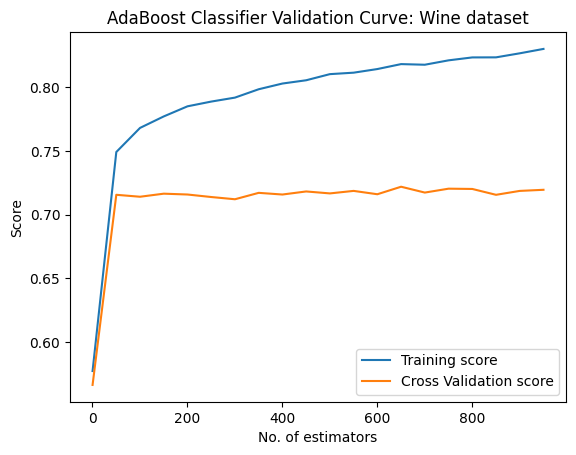

In [176]:
# Validation Curve for no. of weak learners

estimators_vals = np.arange(1, 1001, 50)
init_time = time.time()
train_scores, cv_scores = validation_curve(boosting_clf, X_train, y_train, 
                                           param_name="n_estimators", param_range=estimators_vals,
                                           scoring = 'balanced_accuracy', cv=5, n_jobs=4)
print("Validation curve for no of estimators took {} seconds ".format(time.time() - init_time))
plt.figure()
plt.plot(estimators_vals, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(estimators_vals, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('AdaBoost Classifier Validation Curve: Wine dataset')
plt.xlabel('No. of estimators')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/AB_VC_estim_wine.png')
plt.show()


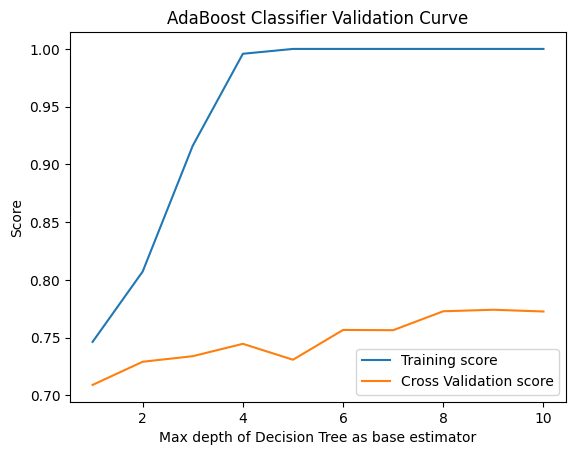

In [177]:
ada_models = []
req_scores = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
acc_train = []
acc_cv = []
for i in range(1,11):
    dt_stump = tree.DecisionTreeClassifier(max_depth = i)
    boost_i = AdaBoostClassifier(base_estimator = dt_stump)
    ada_models.append(boost_i) 
    results = cross_validate(estimator=boost_i, X = X_train, y = y_train, cv = 5, scoring = req_scores, 
                         return_train_score=True)
    
    acc_cv.append(results['test_balanced_accuracy'].mean())
    acc_train.append(results['train_balanced_accuracy'].mean())

plt.figure()
plt.plot(np.arange(1,11), acc_train, label = 'Training score')
plt.plot(np.arange(1,11), acc_cv, label = 'Cross Validation score')
plt.title('AdaBoost Classifier Validation Curve')
plt.xlabel('Max depth of Decision Tree as base estimator')
plt.ylabel('Score')
plt.legend()
plt.show()


Validation curve for no of estimators took 1.4909329414367676 seconds 


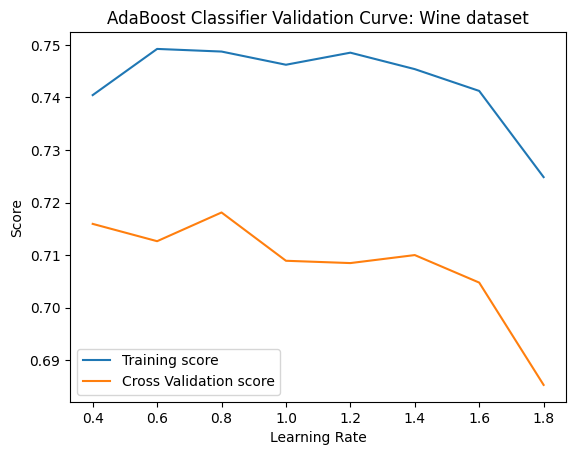

In [179]:
# Validation curve for learning rate
learning_vals = np.arange(0.4, 2, 0.2)
init_time = time.time()
train_scores, cv_scores = validation_curve(boosting_clf, X_train, y_train, 
                                           param_name="learning_rate", param_range=learning_vals, 
                                           scoring = 'balanced_accuracy', cv=5, n_jobs=4)
print("Validation curve for no of estimators took {} seconds ".format(time.time() - init_time))
plt.figure()
plt.plot(learning_vals, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(learning_vals, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('AdaBoost Classifier Validation Curve: Wine dataset')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/AB_VC_lr_wine.png')
plt.show()



In [180]:
# Hyperparameters tuning using GridSearch CV
est_params = np.arange(20, 120, 20)
learn_params = np.arange(0.4,1.2,0.2)


params_gridsearch = {"n_estimators": est_params, "learning_rate": learn_params}
dt_stump = tree.DecisionTreeClassifier(max_depth = 2)
ada_gs = GridSearchCV(AdaBoostClassifier(base_estimator = dt_stump, random_state = 9), 
                      param_grid = params_gridsearch,scoring = 'balanced_accuracy', cv = 5, n_jobs=4)
init_time = time.time()
ada_gs.fit(X_train, y_train)
print("Grid Search took {} seconds ".format(time.time() - init_time))
best_params = ada_gs.best_params_
print("Best parameters: ", best_params)




Grid Search took 5.757448196411133 seconds 
Best parameters:  {'learning_rate': 1.0000000000000002, 'n_estimators': 100}


In [181]:
dt_stump = tree.DecisionTreeClassifier(max_depth = 2)
best_ada = AdaBoostClassifier(random_state = 10, base_estimator = dt_stump, n_estimators = 100, learning_rate = 1.0)
req_scores = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
results = cross_validate(estimator=best_ada, X = X_train, y = y_train, cv = 5, scoring = req_scores, 
                         return_train_score=True)
results
print("Tuned Model Accuracy score", results['test_accuracy'].mean())
print("Tuned Model Balanced Accuracy score", results['test_balanced_accuracy'].mean())
print("Tuned Model F1 score", results['test_f1'].mean())

Tuned Model Accuracy score 0.7768317337362474
Tuned Model Balanced Accuracy score 0.7421174399909074
Tuned Model F1 score 0.8348492900416353


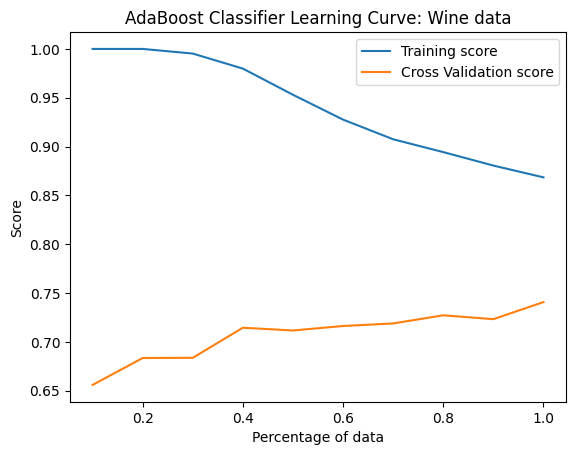

In [182]:
# Learning Curve after tuning. 
dt_stump = tree.DecisionTreeClassifier(max_depth = 2)
best_ada = AdaBoostClassifier(random_state = 10, base_estimator = dt_stump, n_estimators = 100, learning_rate = 1.0)
best_ada.fit(X_train,y_train)
train_data_size = np.linspace(0.1,1,10)
_, train_scores, cv_scores = learning_curve(best_ada, X_train, y_train, train_sizes = train_data_size,
                                            scoring = 'balanced_accuracy', cv = 5, n_jobs = 4)
plt.figure()
plt.plot(train_data_size, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(train_data_size, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('AdaBoost Classifier Learning Curve: Wine data')
plt.xlabel('Percentage of data')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/AB_LC_wine.png')
plt.show()

In [183]:
# Training time 
dt_stump = tree.DecisionTreeClassifier(max_depth = 2)
best_ada = AdaBoostClassifier(random_state = 10, base_estimator = dt_stump, n_estimators = 100, learning_rate = 1.0)
init_time = time.time()
best_ada.fit(X_train,y_train)
print("Training time in seconds:", time.time() - init_time)
init_time = time.time()
y_pred = best_ada.predict(X_test)
print("Query time in seconds:", time.time() - init_time)

Training time in seconds: 0.41032886505126953
Query time in seconds: 0.01836419105529785


In [185]:
print("Tuned Model Test Results")
y_pred = best_ada.predict(X_test)
print("Tuned Model Accuracy score", accuracy_score(y_test,y_pred))
print("Tuned Model Balanced Accuracy score", balanced_accuracy_score(y_test, y_pred))
print("Tuned Model F1 score", f1_score(y_test, y_pred))

Tuned Model Test Results
Tuned Model Accuracy score 0.7700680272108843
Tuned Model Balanced Accuracy score 0.7311888111888112
Tuned Model F1 score 0.8306613226452906


In [186]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       449
           1       0.85      0.81      0.83      1021

    accuracy                           0.77      1470
   macro avg       0.73      0.74      0.74      1470
weighted avg       0.78      0.77      0.77      1470



# KNN

In [187]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
print("Baseline Accuracy score", accuracy_score(y_test,y_pred))
print("Baseline Balanced Accuracy score", balanced_accuracy_score(y_test, y_pred))
print("Baseline F1 score", f1_score(y_test, y_pred))

Baseline Accuracy score 0.7517006802721088
Baseline Balanced Accuracy score 0.7128671328671329
Baseline F1 score 0.8163059889280321


In [188]:
# On cross-validation data
req_scores = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
results = cross_validate(estimator=knn_clf, X = X_train, y = y_train, cv = 5, scoring = req_scores, 
                         return_train_score=True)
results
print("Baseline Accuracy score", results['test_accuracy'].mean())
print("Baseline Balanced Accuracy score", results['test_balanced_accuracy'].mean())
print("Baseline F1 score", results['test_f1'].mean())

Baseline Accuracy score 0.7520452852673917
Baseline Balanced Accuracy score 0.7056646413435479
Baseline F1 score 0.8194868698365635


Validation curve for no of neighbors took 7.471987247467041 seconds 


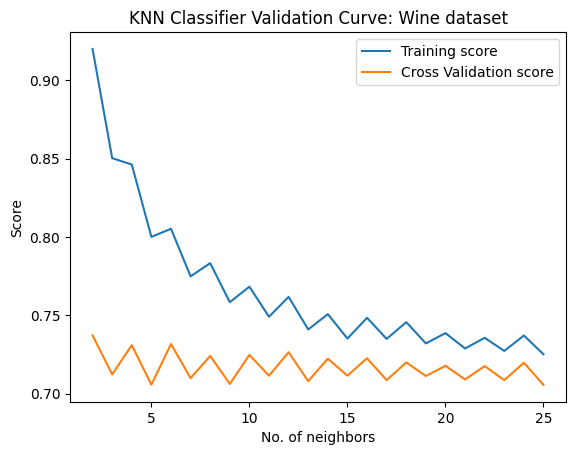

In [192]:
# Validation Curve for no. of neighbors

neigh_vals = np.arange(2, 26, 1)
init_time = time.time()
train_scores, cv_scores = validation_curve(knn_clf, X_train, y_train, 
                                           param_name="n_neighbors", param_range=neigh_vals,
                                           scoring = 'balanced_accuracy',cv=5, n_jobs=4)
print("Validation curve for no of neighbors took {} seconds ".format(time.time() - init_time))
plt.figure()
plt.plot(neigh_vals, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(neigh_vals, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('KNN Classifier Validation Curve: Wine dataset')
plt.xlabel('No. of neighbors')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/KNN_VC_neigh_wine.png')
plt.show()

# No of neighbors should be  9 for good CV score

Validation curve took 0.5905401706695557 seconds 


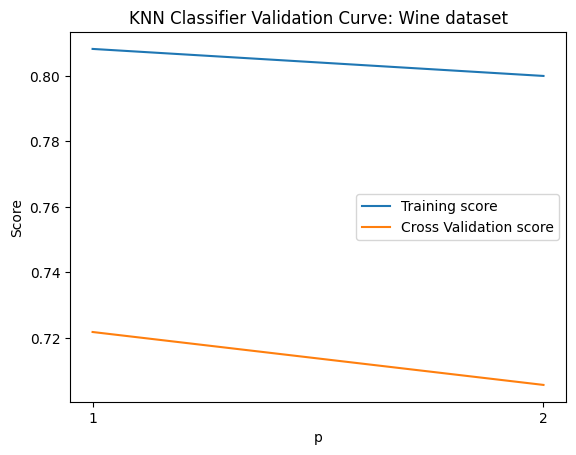

In [195]:
# Validation Curve for p value (1 for Manhattan and 2 for Euclidean)

#leaf_vals = np.arange(10,55,5)
p_vals = [1,2]
p_val_str = ['1','2']
init_time = time.time()
train_scores, cv_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, 
                                           param_name="p", param_range=p_vals, scoring = 'balanced_accuracy',
                                           cv=5, n_jobs=4)
print("Validation curve took {} seconds ".format(time.time() - init_time))
plt.figure()
plt.plot(p_val_str, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(p_val_str, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('KNN Classifier Validation Curve: Wine dataset')
plt.xlabel('p')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/KNN_VC_p_wine.png')
plt.show()

# p as 1 shows good CV score

Validation curve took 8.024426937103271 seconds 


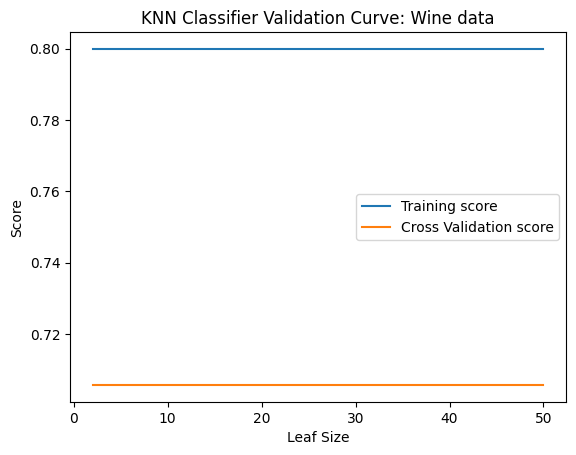

In [196]:
# Validation Curve for leaf_size

leaf_vals = np.arange(2,52,2)
init_time = time.time()
train_scores, cv_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, 
                                           param_name="leaf_size", param_range=leaf_vals,scoring = 'balanced_accuracy',
                                           cv=5, n_jobs=4)
print("Validation curve took {} seconds ".format(time.time() - init_time))
plt.figure()
plt.plot(leaf_vals, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(leaf_vals, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('KNN Classifier Validation Curve: Wine data')
plt.xlabel('Leaf Size')
plt.ylabel('Score')
plt.legend()
plt.show()


In [199]:
# Hyperparameters tuning using GridSearch CV
neigh_params = np.arange(3, 16, 1)
p_params = [1,2]


params_gridsearch = {"n_neighbors": neigh_params, "p": p_params}

knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid = params_gridsearch,scoring = 'balanced_accuracy',
                      cv = 5, n_jobs=4)
init_time = time.time()
knn_gs.fit(X_train, y_train)
print("Grid Search took {} seconds ".format(time.time() - init_time))
best_params = knn_gs.best_params_
print("Best parameters: ", best_params)



Grid Search took 1.7089018821716309 seconds 
Best parameters:  {'n_neighbors': 4, 'p': 1}


In [201]:
# On cross-validated data
best_knn = KNeighborsClassifier(n_neighbors = 4, p = 1)
req_scores = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
results = cross_validate(estimator=best_knn, X = X_train, y = y_train, cv = 5, scoring = req_scores, 
                         return_train_score=True)
results
print("Tuned Model Accuracy score", results['test_accuracy'].mean())
print("Tuned Model Balanced Accuracy score", results['test_balanced_accuracy'].mean())
print("Tuned Model F1 score", results['test_f1'].mean())

Tuned Model Accuracy score 0.7467893852014217
Tuned Model Balanced Accuracy score 0.7380629380705257
Tuned Model F1 score 0.8007855908288981


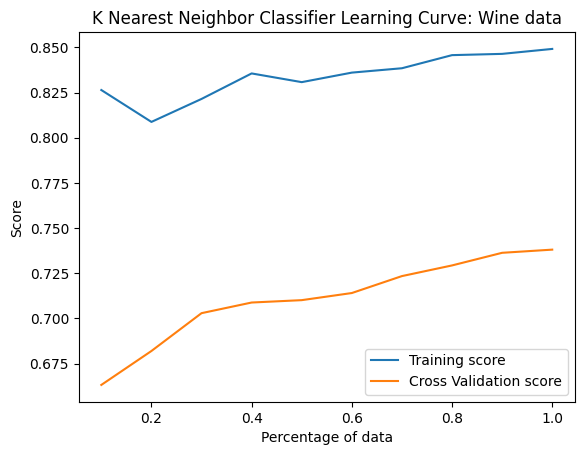

In [202]:
best_knn = KNeighborsClassifier(n_neighbors = 4, p = 1)
best_knn.fit(X_train,y_train)
train_data_size = np.linspace(0.1,1,10)
_, train_scores, cv_scores = learning_curve(best_knn, X_train, y_train, train_sizes = train_data_size, 
                                            scoring = 'balanced_accuracy',cv = 5, n_jobs = 4)
plt.figure()
plt.plot(train_data_size, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(train_data_size, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('K Nearest Neighbor Classifier Learning Curve: Wine data')
plt.xlabel('Percentage of data')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/KNN_LC_wine.png')
plt.show()

In [203]:
# Training time 
best_knn = KNeighborsClassifier(n_neighbors = 4, p = 1)
init_time = time.time()
best_knn.fit(X_train,y_train)
print("Training time in seconds:", time.time() - init_time)
init_time = time.time()
y_pred = best_knn.predict(X_test)
print("Query time in seconds:", time.time() - init_time)

Training time in seconds: 0.00668787956237793
Query time in seconds: 0.10324811935424805


In [204]:
print("Tuned Model Test Results")
y_pred = best_knn.predict(X_test)
print("Tuned Model Accuracy score", accuracy_score(y_test,y_pred))
print("Tuned Model Balanced Accuracy score", balanced_accuracy_score(y_test, y_pred))
print("Tuned Model F1 score", f1_score(y_test, y_pred))

Tuned Model Test Results
Tuned Model Accuracy score 0.7414965986394558
Tuned Model Balanced Accuracy score 0.7325252525252526
Tuned Model F1 score 0.7959183673469388


In [205]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.71      0.60      0.65       583
           1       0.76      0.84      0.80       887

    accuracy                           0.74      1470
   macro avg       0.73      0.72      0.72      1470
weighted avg       0.74      0.74      0.74      1470



# SVM

In [206]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print("Baseline Accuracy score", accuracy_score(y_test,y_pred))
print("Baseline Balanced Accuracy score", balanced_accuracy_score(y_test, y_pred))
print("Baseline F1 score", f1_score(y_test, y_pred))

Baseline Accuracy score 0.7755102040816326
Baseline Balanced Accuracy score 0.7283294483294483
Baseline F1 score 0.8375984251968503


In [207]:
# On cross-validation data
req_scores = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
results = cross_validate(estimator=svm_clf, X = X_train, y = y_train, cv = 5, scoring = req_scores, 
                         return_train_score=True)
results
print("Baseline Accuracy score", results['test_accuracy'].mean())
print("Baseline Balanced Accuracy score", results['test_balanced_accuracy'].mean())
print("Baseline F1 score", results['test_f1'].mean())

Baseline Accuracy score 0.7829609925304846
Baseline Balanced Accuracy score 0.7340957757474534
Baseline F1 score 0.8439822422158884


Validation curve took 3.7107319831848145 seconds 


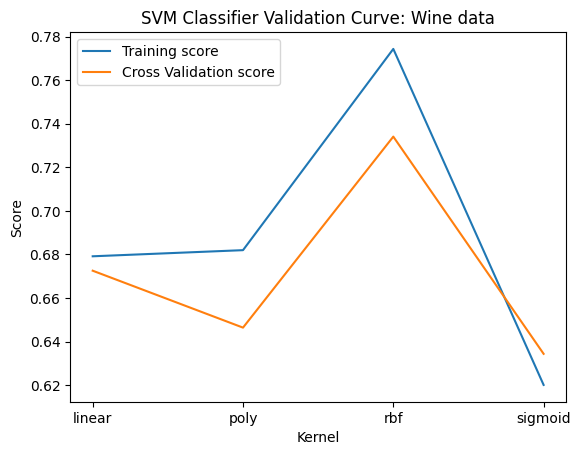

In [208]:
# Validation Curve for kernels

kernel_vals = ['linear', 'poly','rbf', 'sigmoid']
init_time = time.time()
train_scores, cv_scores = validation_curve(svm_clf, X_train, y_train, 
                                           param_name="kernel", param_range=kernel_vals, 
                                           scoring = 'balanced_accuracy',cv=5, n_jobs=4)
print("Validation curve took {} seconds ".format(time.time() - init_time))
plt.figure()
plt.plot(kernel_vals, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(kernel_vals, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('SVM Classifier Validation Curve: Wine data')
plt.xlabel('Kernel')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/SVM_VC_kernel_wine.png')
plt.show()



Validation curve took 5.118610858917236 seconds 


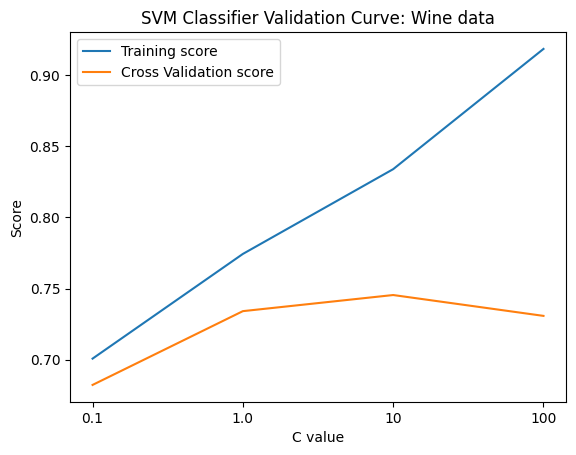

In [209]:
# Validation Curve for C with default (rbf) kernel

#C_vals = [0.1, 0.5, 1, 5, 10, 20, 40, 60, 80,100, 150, 200, 250, 300, 400, 500, 600, 800, 1000]
C_vals = [0.1, 1, 10, 100]
C_vals_str = ['0.1', '1.0', '10', '100']
init_time = time.time()
train_scores, cv_scores = validation_curve(SVC(), X_train, y_train, 
                                           param_name="C", param_range=C_vals,
                                           scoring = 'balanced_accuracy',cv=5, n_jobs=4)
print("Validation curve took {} seconds ".format(time.time() - init_time))
plt.figure()
plt.plot(C_vals_str, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(C_vals_str, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('SVM Classifier Validation Curve: Wine data')
plt.xlabel('C value')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/SVM_VC_C_wine.png')
plt.show()

Validation curve took 6.056818962097168 seconds 


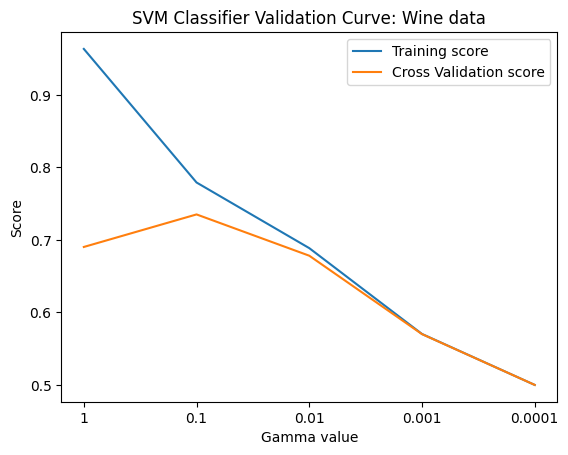

In [210]:
# Validation Curve for gamma with default (rbf) kernel

gamma_vals = [1, 0.1, 0.01, 0.001, 0.0001]
g_val_str = ['1', '0.1', '0.01', '0.001', '0.0001']
init_time = time.time()
train_scores, cv_scores = validation_curve(SVC(), X_train, y_train, 
                                           param_name="gamma", param_range=gamma_vals, 
                                           scoring = 'balanced_accuracy',cv=5, n_jobs=4)
print("Validation curve took {} seconds ".format(time.time() - init_time))
plt.figure()
plt.plot(g_val_str, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(g_val_str, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('SVM Classifier Validation Curve: Wine data')
plt.xlabel('Gamma value')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/SVM_VC_gamma_wine.png')
plt.show()

In [49]:
# Hyperparameters tuning using GridSearch CV
# DO not run this; takes forever
# kernel_vals = ['linear', 'poly','rbf', 'sigmoid']
# C_vals = [0.1, 1, 10, 100]
# gamma_vals = [1, 0.1, 0.01, 0.001, 0.0001]

# params_gridsearch = {"kernel": kernel_vals, "C": C_vals, "gamma": gamma_vals}

# svc_gs = GridSearchCV(SVC(), param_grid = params_gridsearch, cv = 5, n_jobs=4)
# init_time = time.time()
# svc_gs.fit(X_train, y_train)
# print("Grid Search took {} seconds ".format(time.time() - init_time))
# best_params = svc_gs.best_params_
# print("Best parameters: ", best_params)




In [214]:
# On cross-validated data
best_svc = SVC(kernel = 'rbf', C = 1.0, gamma = 0.01)
req_scores = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
results = cross_validate(estimator=best_svc, X = X_train, y = y_train, cv = 5, scoring = req_scores, 
                         return_train_score=True)
results
print("Tuned Model Accuracy score", results['test_accuracy'].mean())
print("Tuned Model Balanced Accuracy score", results['test_balanced_accuracy'].mean())
print("Tuned Model F1 score", results['test_f1'].mean())

Tuned Model Accuracy score 0.75290757804686
Tuned Model Balanced Accuracy score 0.6782302260888574
Tuned Model F1 score 0.829673112359673


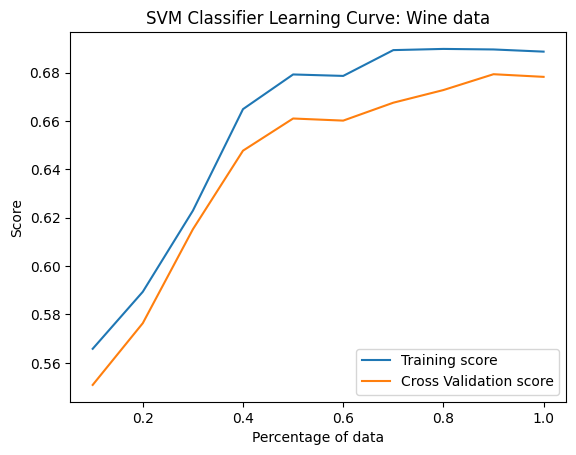

In [216]:
# Learning Curve for SVM
best_svc = SVC(kernel = 'rbf', C = 1.0, gamma = 0.01)
best_svc.fit(X_train,y_train)
train_data_size = np.linspace(0.1,1,10)
_, train_scores, cv_scores = learning_curve(best_svc, X_train, y_train, train_sizes = train_data_size, 
                                            scoring = 'balanced_accuracy',cv = 5, n_jobs = 4)
plt.figure()
plt.plot(train_data_size, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(train_data_size, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('SVM Classifier Learning Curve: Wine data')
plt.xlabel('Percentage of data')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/SVM_LC_wine.png')
plt.show()

In [217]:
# Training & Predicting time 
best_svc = SVC(kernel = 'rbf', C = 1.0, gamma = 0.01)
init_time = time.time()
best_svc.fit(X_train,y_train)
print("Training time in seconds:", time.time() - init_time)
init_time = time.time()
y_pred = best_svc.predict(X_test)
print("Query time in seconds:", time.time() - init_time)

Training time in seconds: 0.33959317207336426
Query time in seconds: 0.23912882804870605


In [218]:
print("Tuned Model Test Results")
y_pred = best_svc.predict(X_test)
print("Tuned Model Accuracy score", accuracy_score(y_test,y_pred))
print("Tuned Model Balanced Accuracy score", balanced_accuracy_score(y_test, y_pred))
print("Tuned Model F1 score", f1_score(y_test, y_pred))

Tuned Model Test Results
Tuned Model Accuracy score 0.7639455782312925
Tuned Model Balanced Accuracy score 0.6992229992229992
Tuned Model F1 score 0.8345255126371007


In [219]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.50      0.71      0.59       348
           1       0.90      0.78      0.83      1122

    accuracy                           0.76      1470
   macro avg       0.70      0.75      0.71      1470
weighted avg       0.80      0.76      0.78      1470



# Neural Network

In [220]:
nn_clf = MLPClassifier(random_state = 31, hidden_layer_sizes = (11,2), max_iter = 2000)
nn_clf.fit(X_train, y_train)
y_pred = nn_clf.predict(X_test)
print("Baseline Accuracy score", accuracy_score(y_test,y_pred))
print("Baseline Balanced Accuracy score", balanced_accuracy_score(y_test, y_pred))
print("Baseline F1 score", f1_score(y_test, y_pred))

Baseline Accuracy score 0.7693877551020408
Baseline Balanced Accuracy score 0.7311732711732711
Baseline F1 score 0.8299046663321625


In [221]:
# On cross-validation data
req_scores = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
results = cross_validate(estimator=nn_clf, X = X_train, y = y_train, cv = 5, scoring = req_scores, 
                         return_train_score=True)
results
print("Baseline Accuracy score", results['test_accuracy'].mean())
print("Baseline Balanced Accuracy score", results['test_balanced_accuracy'].mean())
print("Baseline F1 score", results['test_f1'].mean())

Baseline Accuracy score 0.7707071566895788
Baseline Balanced Accuracy score 0.7307704253538972
Baseline F1 score 0.8317645524411711


Validation curve took 11.273774147033691 seconds 


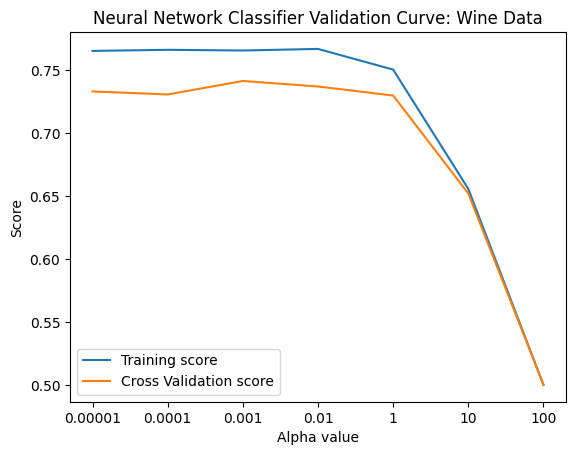

In [222]:
# Validation curve of alpha (Regularization parameter)
alpha_val = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100]
alpha_val_str = ['0.00001', '0.0001', '0.001', '0.01', '1', '10','100']
init_time = time.time()
train_scores, cv_scores = validation_curve(nn_clf, X_train, y_train, 
                                           param_name="alpha", param_range=alpha_val, 
                                           scoring = 'balanced_accuracy',cv=5, n_jobs=4)
print("Validation curve took {} seconds ".format(time.time() - init_time))
plt.figure()
plt.plot(alpha_val_str, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(alpha_val_str, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('Neural Network Classifier Validation Curve: Wine Data')
plt.xlabel('Alpha value')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/NN_VC_alpha_wine.png')
plt.show()

Validation curve took 6.615587949752808 seconds 


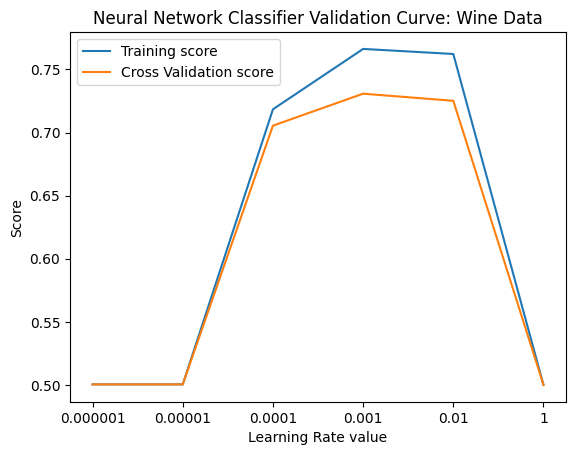

In [223]:
# Validation curve of learning rate
lr_val = [0.000001,0.00001, 0.0001, 0.001, 0.01, 1]
lr_val_str = ['0.000001','0.00001', '0.0001', '0.001', '0.01', '1']
init_time = time.time()
train_scores, cv_scores = validation_curve(nn_clf, X_train, y_train, 
                                           param_name="learning_rate_init", param_range=lr_val,
                                           scoring = 'balanced_accuracy',cv=5, n_jobs=4)
print("Validation curve took {} seconds ".format(time.time() - init_time))
plt.figure()
plt.plot(lr_val_str, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(lr_val_str, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('Neural Network Classifier Validation Curve: Wine Data')
plt.xlabel('Learning Rate value')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/NN_VC_lr_wine.png')
plt.show()

Validation curve took 7.650618314743042 seconds 


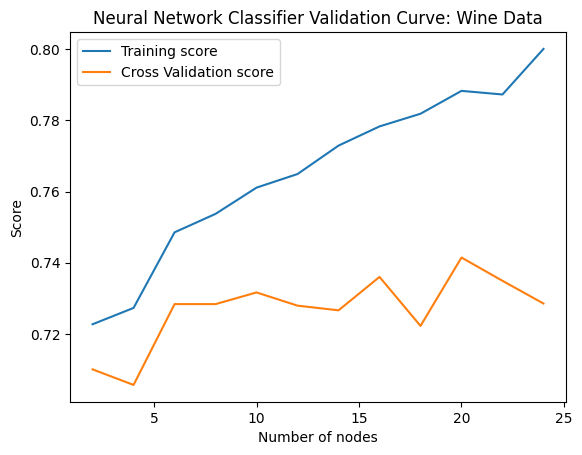

In [224]:
# Validation curve of  hidden layer size
hidd_val = np.arange(2,25,2)
nn_clf = MLPClassifier(random_state = 32, alpha = 0.001, learning_rate_init = 0.01, max_iter = 2000)
init_time = time.time()
hidd_val_s =[(i,) for i in hidd_val]
train_scores, cv_scores = validation_curve(nn_clf, X_train, y_train, 
                                           param_name="hidden_layer_sizes", param_range=hidd_val_s, 
                                           scoring = 'balanced_accuracy',cv=5, n_jobs=4)
print("Validation curve took {} seconds ".format(time.time() - init_time))
plt.figure()
plt.plot(hidd_val, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(hidd_val, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('Neural Network Classifier Validation Curve: Wine Data')
plt.xlabel('Number of nodes')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/NN_VC_hidden_wine.png')
plt.show()

In [225]:
# Hyperparameters tuning using GridSearch CV
alpha_val = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100]
lr_val = [0.000001,0.00001, 0.0001, 0.001, 0.01, 1]
hidden_val = np.arange(2,25,2)
nn_clf = MLPClassifier(random_state = 32, max_iter = 2000)

params_gridsearch = {"alpha": alpha_val, "learning_rate_init": lr_val, "hidden_layer_sizes": hidden_val}

knn_gs = GridSearchCV(nn_clf, param_grid = params_gridsearch, scoring = 'balanced_accuracy',cv = 5, n_jobs=4)
init_time = time.time()
knn_gs.fit(X_train, y_train)
print("Grid Search took {} seconds ".format(time.time() - init_time))
best_params = knn_gs.best_params_
print("Best parameters: ", best_params)


/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anura

/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anura

/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anura

/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anura

/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anura

Grid Search took 1284.7416439056396 seconds 
Best parameters:  {'alpha': 0.0001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001}


/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anurag/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anura

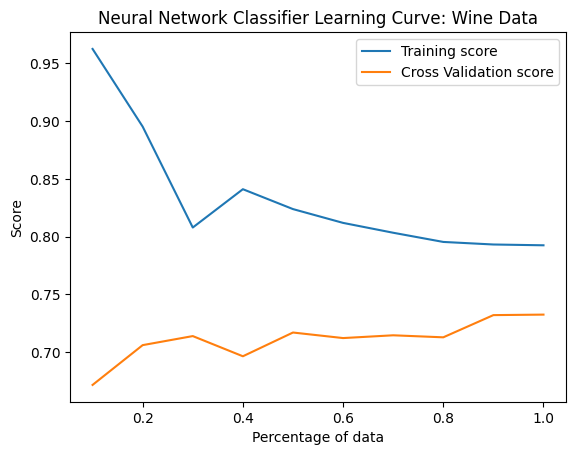

In [226]:
# Learning Curve for NN
best_nn = MLPClassifier(random_state = 33, hidden_layer_sizes = (20,2), max_iter = 2000, alpha = 0.0001, learning_rate_init = 0.001)
best_nn.fit(X_train,y_train)
train_data_size = np.linspace(0.1,1,10)
_, train_scores, cv_scores = learning_curve(best_nn, X_train, y_train, train_sizes = train_data_size,
                                            scoring = 'balanced_accuracy',cv = 5, n_jobs = 4)
plt.figure()
plt.plot(train_data_size, np.mean(train_scores, axis = 1), label = 'Training score')
plt.plot(train_data_size, np.mean(cv_scores, axis = 1), label = 'Cross Validation score')
plt.title('Neural Network Classifier Learning Curve: Wine Data')
plt.xlabel('Percentage of data')
plt.ylabel('Score')
plt.legend()
plt.savefig('./plots/NN_LC_wine.png')
plt.show()

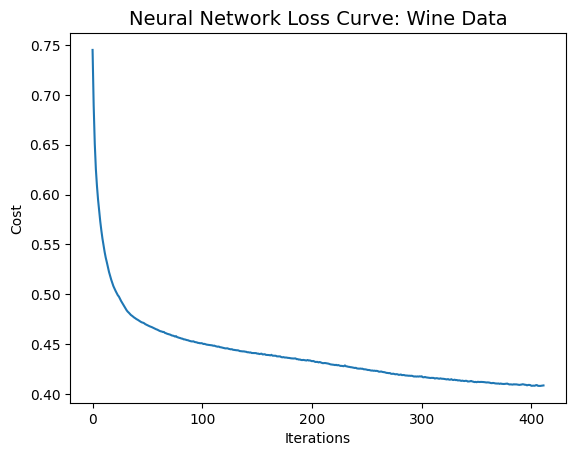

In [227]:
nn_clf1 = MLPClassifier(random_state = 35, hidden_layer_sizes = (20,2), max_iter = 2000, 
                       alpha = 0.0001, learning_rate_init = 0.001, solver = 'adam')
nn_clf1.fit(X_train1, y_train1)
plt.plot(nn_clf1.loss_curve_)
plt.title("Neural Network Loss Curve: Wine Data", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.savefig('./plots/NN_Loss_wine.png')
plt.show()


In [228]:
# On cross-validated data
nn_clf1 = MLPClassifier(random_state = 35, hidden_layer_sizes = (20,2), max_iter = 2000, 
                       alpha = 0.0001, learning_rate_init = 0.001, solver = 'adam')
req_scores = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
results = cross_validate(estimator=nn_clf1, X = X_train, y = y_train, cv = 5, scoring = req_scores, 
                         return_train_score=True)
results
print("Tuned Model Accuracy score", results['test_accuracy'].mean())
print("Tuned Model Balanced Accuracy score", results['test_balanced_accuracy'].mean())
print("Tuned Model F1 score", results['test_f1'].mean())

Tuned Model Accuracy score 0.7707054542359175
Tuned Model Balanced Accuracy score 0.7264208463525492
Tuned Model F1 score 0.8332292474702916


In [229]:
# Training & Predicting time 
nn_clf1 = MLPClassifier(random_state = 35, hidden_layer_sizes = (20,2), max_iter = 2000, 
                       alpha = 0.0001, learning_rate_init = 0.001, solver = 'adam')
init_time = time.time()
nn_clf1.fit(X_train,y_train)
print("Training time in seconds:", time.time() - init_time)
init_time = time.time()
y_pred = nn_clf1.predict(X_test)
print("Query time in seconds:", time.time() - init_time)

Training time in seconds: 2.5309009552001953
Query time in seconds: 0.0029549598693847656


In [230]:
print("Tuned Model Test Results")
y_pred = nn_clf1.predict(X_test)
print("Tuned Model Accuracy score", accuracy_score(y_test,y_pred))
print("Tuned Model Balanced Accuracy score", balanced_accuracy_score(y_test, y_pred))
print("Tuned Model F1 score", f1_score(y_test, y_pred))

Tuned Model Test Results
Tuned Model Accuracy score 0.773469387755102
Tuned Model Balanced Accuracy score 0.7392229992229993
Tuned Model F1 score 0.8317331985851442


In [231]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       466
           1       0.84      0.82      0.83      1004

    accuracy                           0.77      1470
   macro avg       0.74      0.75      0.74      1470
weighted avg       0.78      0.77      0.78      1470

